<a href="https://colab.research.google.com/github/rafayhabibullah/Quant-Analysis/blob/master/BTC_Weekly_SIP_with_multiple_ma_strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data loaded: 580 rows

=== FINAL SUMMARY ===
        total_invested_usd  final_btc  last_price_usd  portfolio_value_usd  \
MA_20               3843.0   0.114372   109221.617188         12491.930747   
MA_32               3675.0   0.111826   109221.617188         12213.779365   
MA_50               3150.0   0.102788   109221.617188         11226.725216   
MA_100              3423.0   0.116607   109221.617188         12735.982001   
MA_200              2793.0   0.094405   109221.617188         10311.085034   
Hybrid              4137.0   0.136399   109221.617188         14897.672448   

        avg_buy_price_usd_per_btc     roi_pct  days_invested  
MA_20                33600.784647  225.056746          261.0  
MA_32                32863.655972  232.347738          261.0  
MA_50                30645.454264  256.403975          261.0  
MA_100               29355.066269  272.070757          261.0  
MA_200               29585.244987  269.175977          261.0  
Hybrid               30330.229

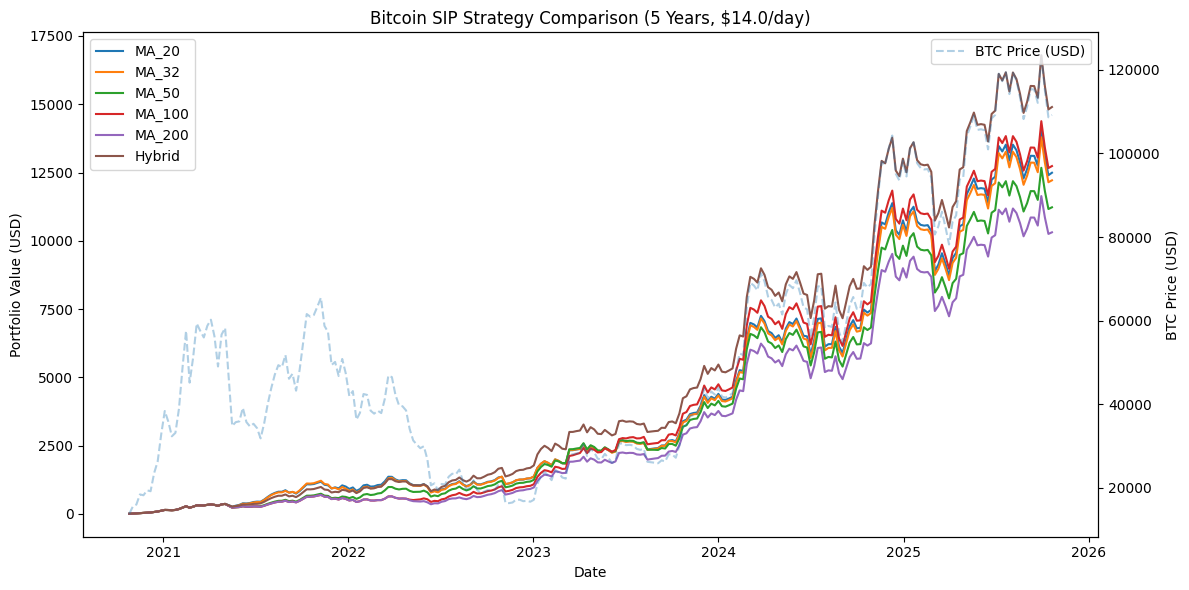

In [17]:
# -------------------------
# BTC SIP Backtest (5 Years, 5 Strategies)
# -------------------------

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
import math

# -------------------------
# PARAMETERS
# -------------------------
base_daily_usd = 14.0
period_years = 5
end_date = datetime.now(timezone.utc).date()
start_date = end_date - timedelta(days=365 * period_years)
ticker = "BTC-USD"

save_csv = "btc_sip_summary.csv"
save_png = "btc_sip_chart.png"

# -------------------------
# HELPER FUNCTIONS
# -------------------------
def to_float(x):
    """Safely convert scalars or 1-element Series/arrays to float."""
    if isinstance(x, pd.Series):
        if len(x) > 0:
            return float(x.iloc[0])
        else:
            return np.nan
    elif isinstance(x, (np.ndarray, list)):
        if len(x) > 0:
            return float(x[0])
        else:
            return np.nan
    try:
        return float(x)
    except Exception:
        return np.nan

def rsi(series, period=14, isSmoothing=False, smoothing=14):
    # Calculate price changes
    delta = series.diff()

    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Calculate rolling averages for gains and losses
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    # Avoid division by zero
    rs = avg_gain / (avg_loss + 1e-12)
    rsi_raw = 100 - (100 / (1 + rs))

    # Apply simple moving average smoothing
    rsi_smooth = rsi_raw.rolling(window=smoothing, min_periods=1).mean()

    return rsi_raw if not isSmoothing else rsi_smooth

# -------------------------
# FETCH DATA
# -------------------------
print(f"Downloading {ticker} data...")
df_all = yf.download(
    ticker,
    start="2010-01-01",       # BTC history starts 2010–2011
    end=(end_date + timedelta(days=1)).strftime("%Y-%m-%d"),
    interval="1wk",
    progress=False,
    auto_adjust=False
)

df_all = df_all[["Close"]].rename(columns={"Close": "close"})
df_all.index = pd.to_datetime(df_all.index).date
df_all = df_all.sort_index()

print(f"Data loaded: {len(df_all)} rows")

# -------------------------
# CALCULATE INDICATORS
# -------------------------
df_all["ma20"] = df_all["close"].rolling(window=20, min_periods=1).mean()
df_all["ma32"] = df_all["close"].rolling(window=32, min_periods=1).mean()
df_all["ma50"] = df_all["close"].rolling(window=50, min_periods=1).mean()
df_all["ma100"] = df_all["close"].rolling(window=100, min_periods=1).mean()
df_all["ma200"] = df_all["close"].rolling(window=200, min_periods=1).mean()
df_all["rsi14"] = rsi(df_all["close"], period=14, isSmoothing=False)
df_all["daily_pct"] = df_all["close"].pct_change() * 100

# -------------------------
# BUY STRATEGIES
# -------------------------
def buy_ma20(date, row, df_all):
    close = to_float(row["close"])
    ma20 = to_float(row["ma20"])
    return base_daily_usd * (2.0 if close < ma20 else 0.5)

def buy_ma32(date, row, df_all):
    close = to_float(row["close"])
    ma32 = to_float(row["ma32"])
    return base_daily_usd * (2.0 if close < ma32 else 0.5)

def buy_ma50(date, row, df_all):
    close = to_float(row["close"])
    ma50 = to_float(row["ma50"])
    return base_daily_usd * (2.0 if close < ma50 else 0.5)

def buy_ma100(date, row, df_all):
    close = to_float(row["close"])
    ma100 = to_float(row["ma100"])
    return base_daily_usd * (2.0 if close < ma100 else 0.5)

def buy_ma200(date, row, df_all):
    close = to_float(row["close"])
    ma200 = to_float(row["ma200"])
    return base_daily_usd * (2.0 if close < ma200 else 0.5)

def buy_hybrid(date, row, df_all):
    close = to_float(row["close"])
    ma20 = to_float(row["ma20"])
    ma50 = to_float(row["ma50"])
    ma200 = to_float(row["ma200"])
    rsi_val = to_float(row["rsi14"])
    daily_pct = to_float(row["daily_pct"])
    usd = base_daily_usd
    add_mult = 0.0

    if close < ma200: add_mult += 1.0
    if close < ma50: add_mult += 1.0
    if daily_pct <= -5: add_mult += 1.0

    usd = usd * (1 + add_mult)

    # reduce when overbought
    if close > ma20:
        usd = base_daily_usd * 0.5

    return usd

# -------------------------
# SIMULATOR
# -------------------------
def simulate_strategy(df, buy_rule_fn):
    df2 = df.copy()
    df2["usd_invested"] = 0.0
    df2["btc_bought"] = 0.0

    for d, row in df2.iterrows():
        usd = to_float(buy_rule_fn(d, row, df2))
        price = to_float(row["close"])

        if np.isnan(price) or price <= 0 or usd <= 0:
            df2.at[d, "usd_invested"] = 0.0
            df2.at[d, "btc_bought"] = 0.0
            continue

        btc = usd / price
        df2.at[d, "usd_invested"] = usd
        df2.at[d, "btc_bought"] = btc

    df2["cum_usd"] = df2["usd_invested"].cumsum()
    df2["cum_btc"] = df2["btc_bought"].cumsum()

    last_price = to_float(df2["close"].iloc[-1])
    final_btc = to_float(df2["cum_btc"].iloc[-1])
    total_invested = to_float(df2["cum_usd"].iloc[-1])
    portfolio_value = final_btc * last_price
    avg_buy_price = total_invested / final_btc if final_btc > 0 else np.nan
    roi_pct = (portfolio_value - total_invested) / total_invested * 100 if total_invested > 0 else np.nan

    stats = {
        "total_invested_usd": total_invested,
        "final_btc": final_btc,
        "last_price_usd": last_price,
        "portfolio_value_usd": portfolio_value,
        "avg_buy_price_usd_per_btc": avg_buy_price,
        "roi_pct": roi_pct,
        "days_invested": int((df2["usd_invested"] > 0).sum())
    }
    return df2, stats

# -------------------------
# RUN STRATEGIES
# -------------------------
strategies = {
    "MA_20": buy_ma20,
    "MA_32": buy_ma32,
    "MA_50": buy_ma50,
    "MA_100": buy_ma100,
    "MA_200": buy_ma200,
    "Hybrid": buy_hybrid
}

results = {}
frames = {}

end_date = datetime.now(timezone.utc).date()
start_date = end_date - timedelta(days=365 * 5)
df = df_all[df_all.index >= start_date]

for name, fn in strategies.items():
    frame, stats = simulate_strategy(df, fn)
    results[name] = stats
    frames[name] = frame

# -------------------------
# SUMMARY
# -------------------------
summary = pd.DataFrame(results).T
summary = summary[[
    "total_invested_usd",
    "final_btc",
    "last_price_usd",
    "portfolio_value_usd",
    "avg_buy_price_usd_per_btc",
    "roi_pct",
    "days_invested"
]]
summary.to_csv(save_csv)
print("\n=== FINAL SUMMARY ===")
print(summary)

# -------------------------
# PLOT RESULTS
# -------------------------
plt.figure(figsize=(12, 6))
for name, frame in frames.items():
    frame = frame.copy()
    frame["port_value"] = frame["cum_btc"].to_numpy().ravel() * frame["close"].to_numpy().ravel()
    plt.plot(frame.index, frame["port_value"], label=name)

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(df.index, df["close"], "--", alpha=0.35, label="BTC Price (USD)")
ax.set_xlabel("Date")
ax.set_ylabel("Portfolio Value (USD)")
ax2.set_ylabel("BTC Price (USD)")
ax.set_title(f"Bitcoin SIP Strategy Comparison ({period_years} Years, ${base_daily_usd}/day)")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.savefig(save_png, dpi=150)
plt.show()
